# Interest rate models

In this project we will test simulations of different interest rate models. These models can be used to simulate possible future interest rate scenarios, aiding in economic forecasting and strategic planning for financial institutions, pricing financial instruments and valuing derivatives as well as aid in risk management.

## Vasicek model

The Vasicek model provides a framework for describing how interest rates evolve over time in a stochastic manner. It assumes that interest rates can be described by a simple mean reverting stochastic process with one source of uncertainty coming from a Brownian motion. It sets up the short-term interest rate as a process that evolves as a stochastic process where over time, where the process tends to drift towards a long-term mean (mean reverting). The model is attractive in that it is tractable and well understood.

It is formulated as a type of Stochastic Differential Equation (SDE), which captures the random fluctuations in interest rates as well as their tendency to revert to a long-term mean:

$$
dr_t = a(b - r_t)\,dt + \sigma\,dW_t
$$

where a is speed of reversion, b is the long-term mean and $\sigma$ is the instantaneous volatility.


Solving the stochastic differential equation gets:

$$
r_t = r_0 e^{-at} + b(1 - e^{-at}) + \sigma e^{-at} \int_0^t e^{as}\,dW_s
$$

The stochastic integral term:

$$
\sigma e^{-at} \int_0^t e^{as} \, dW_s
$$

is normally distributed with:

- Mean: $0$
- Variance: $\sigma^2 \cdot \dfrac{1 - e^{-2at}}{2a}$

Therefore, to simulate this term in discrete time with time step $\Delta t$, we draw a standard normal random variable and compute:

$$
\sigma \sqrt{ \frac{1 - e^{-2a\Delta t}}{2a} } \cdot \varepsilon
$$


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's set up the Vasicek model and test it out.

In [3]:
def vasicek_model(r0: float, 
                  a: float, 
                  b: float, 
                  sigma: float, 
                  T: int, 
                  dt: float) -> pd.DataFrame:
    """ Simulates a time series of interest rates using the One Factor Vasicek model
    
    Args:
      r0 (float): starting interest rate of the vasicek process 
      a (float): speed of reversion" parameter that characterizes the velocity at which such trajectories will regroup around b in time
      b (float): long term mean level that all future trajectories will evolve around  
      sigma (float): instantaneous volatility measures instant by instant the amplitude of randomness entering the system
      T (integer): end modelling time. From 0 to T the time series runs. 
      dt (float): increment of time that the process runs on. Ex. dt = 0.1 then the time series is 0, 0.1, 0.2,...
    
    Returns:
      N x 2 Pandas DataFrame where index is modelling time and values are a realisation of the underlying's price
    """
    
    N = int(T / dt) + 1 # number of intervals of length 1/dt between 0 and max modelling time T

    time, delta_t = np.linspace(0, T, num = N, retstep = True)

    r = np.ones(N) * r0

    for t in range(1,N):
        r[t] = r[t-1] * np.exp(-a*dt)+b*(1-np.exp(-a*dt))+sigma*np.sqrt((1-np.exp(-2*a*dt))/(2*a))* np.random.normal(loc = 0,scale = 1)

    dict = {'Time' : time, 'Interest Rate' : r}

    interest_rate_simulation = pd.DataFrame.from_dict(data = dict)
    interest_rate_simulation.set_index('Time', inplace = True)

    return interest_rate_simulation

In [4]:
r0 = 2    # The starting interest rate
a = 0.05     # Speed of reversion parameter
b = 2   # Long-term mean interest rate level correction
sigma = 0.2 # Instantaneous volatility
T = 200      # End modelling time
dt = 0.01    # Increments of time

print(vasicek_model(r0, a, b, sigma, T, dt))

        Interest Rate
Time                 
0.00         2.000000
0.01         2.006514
0.02         2.018435
0.03         2.010372
0.04         1.999495
...               ...
199.96       2.025613
199.97       2.031522
199.98       2.063263
199.99       2.039300
200.00       2.044327

[20001 rows x 1 columns]


OK that looks good, we got interest rates that have a start point at 2 per cent and a long-term interest rate level at 2 per cent with 200 time steps and 0.05 mean reversion. Let's simulate a couple of paths below.

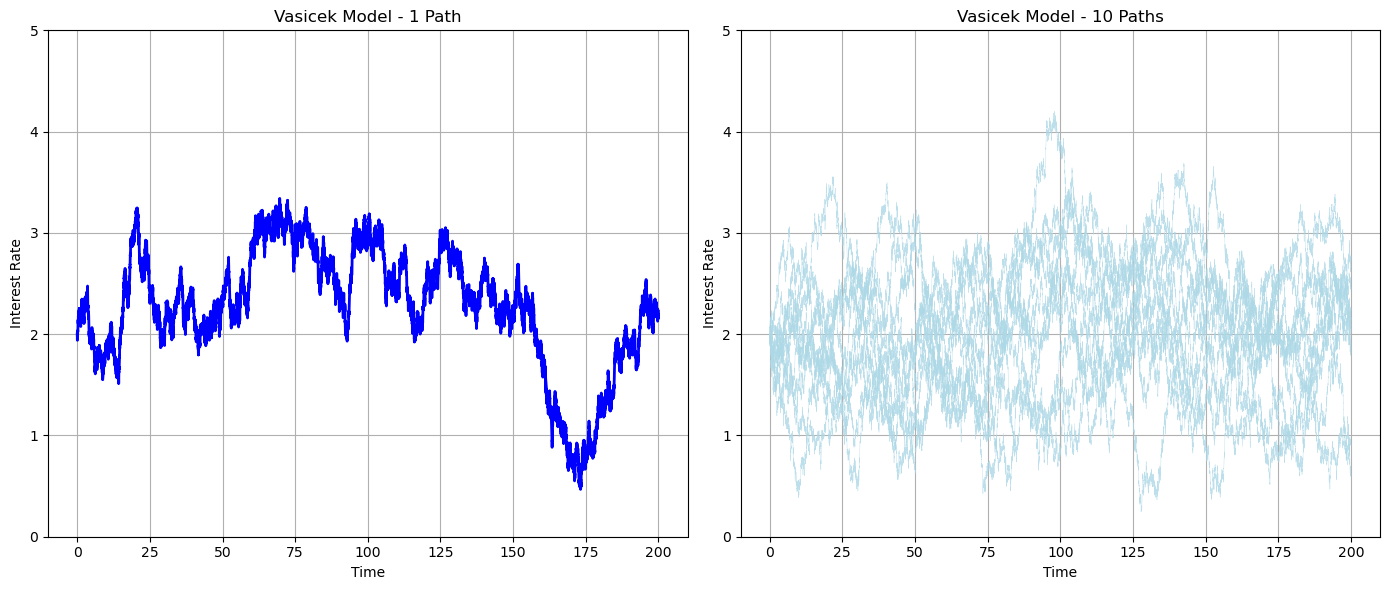

In [5]:
plt.figure(figsize=(14, 6))

# Left: Single example path
plt.subplot(1, 2, 1)
rate = vasicek_model(r0, a, b, sigma, T, dt)
plt.plot(rate.index, rate['Interest Rate'], color='blue', linewidth=2)
plt.title('Vasicek Model - 1 Path')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.ylim([0, 5])  # zoomed out y-limit

nn=10
plt.subplot(1, 2, 2)
for _ in range(nn):
    rate = vasicek_model(r0, a, b, sigma, T, dt)
    plt.plot(rate.index, rate['Interest Rate'], color='lightblue', alpha=0.8, linewidth=0.3)
plt.title(f'Vasicek Model - {nn} Paths')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.ylim([0, 5])  # same zoomed out y-limit

plt.tight_layout()
plt.show()


OK that looks good. Let's download data for US 3-month Treasury bill yields and fit a Vasicek model onto it to what optimal parameters it uses and see how it would forecast the future evolution of 3-month bills.

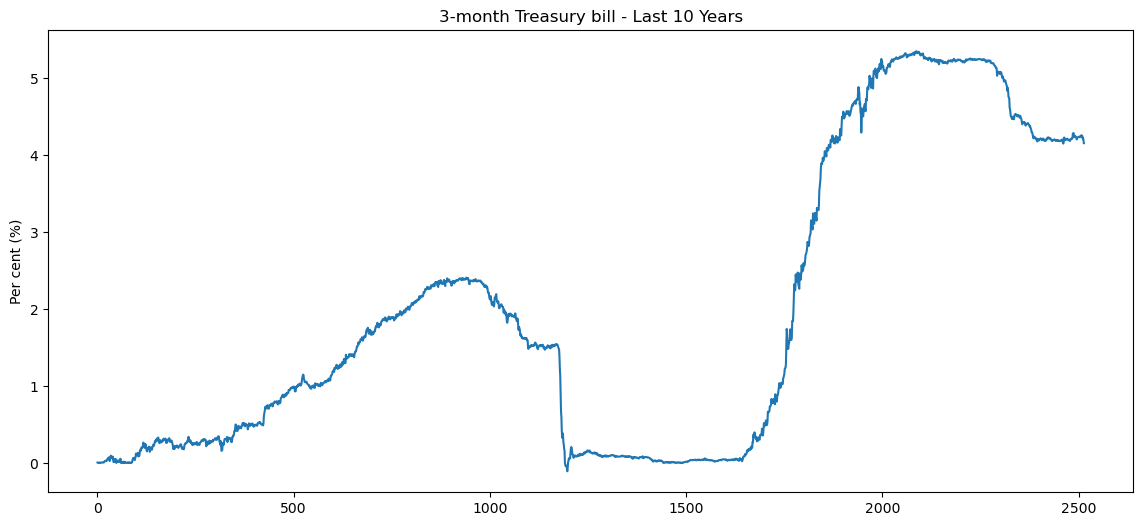

In [10]:
import yfinance as yf

# Get 3-month Treasury bill
tnx = yf.Ticker("^IRX")

hist = tnx.history(period="10y")

yields = hist["Close"]
yields = yields.dropna().reset_index(drop=True)


yields.plot(figsize=(14, 6), title="3-month Treasury bill - Last 10 Years", ylabel="Per cent (%)")
plt.show()

OK so we have 10 years worth of data. Let's use the Vasicek model function and fit to the actual data using scipy by minimizing the error function.

Optimized parameters:
a: 0.0100, b: 2.0259, sigma: 0.0222


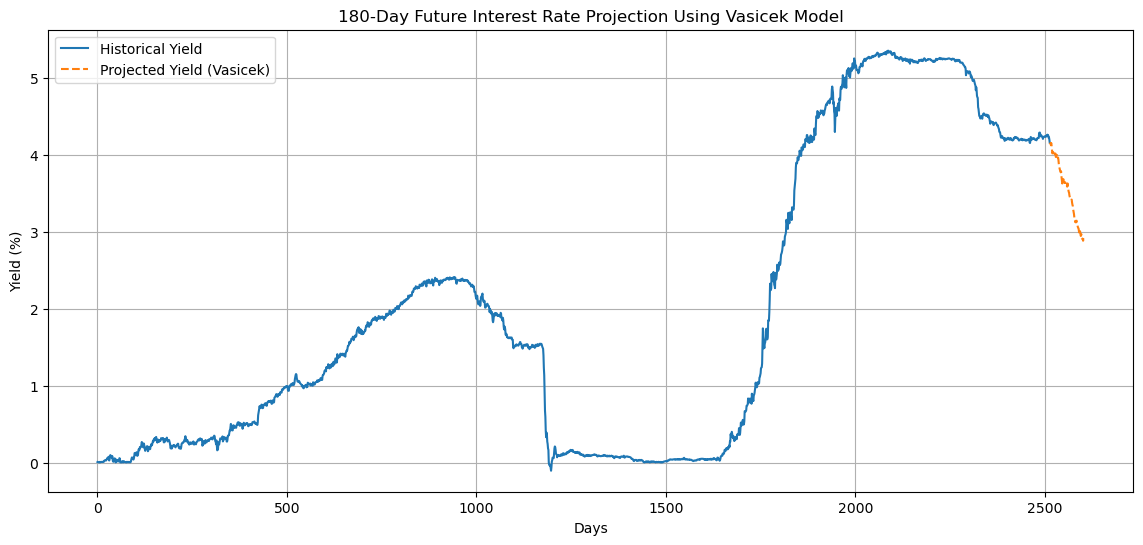

In [11]:
from scipy.optimize import minimize

def vasicek_model(r0, a, b, sigma, T, dt):
    """Simulates interest rate path using the Vasicek model."""
    N = int(T / dt)
    rates = np.zeros(N + 1)
    rates[0] = r0
    for t in range(1, N + 1):
        dr = a * (b - rates[t - 1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates[t] = rates[t - 1] + dr
    return rates

# 2. Objective Function for Calibration
def objective(params, yields):
    a, b, sigma = params
    np.random.seed(30)  # For reproducibility
    simulated = vasicek_model(r0=yields.iloc[0], a=a, b=b, sigma=sigma, T=len(yields)-1, dt=1.0)
    return np.mean((simulated - yields.values) ** 2)


# 4. Optimization
initial_guess = [0.1, yields.mean(), 0.1]
bounds = [(0.01, 1), (0, 6), (0.01, 1)]

result = minimize(objective, initial_guess, args=(yields,), bounds=bounds)
a_opt, b_opt, sigma_opt = result.x
print(f"Optimized parameters:\na: {a_opt:.4f}, b: {b_opt:.4f}, sigma: {sigma_opt:.4f}")

# 7. Simulate Future 180-day Path
future_simulation = vasicek_model(r0=yields.iloc[-1], a=a_opt, b=b_opt, sigma=sigma_opt, T=90, dt=1.0)

# 8. Plot Future Projection
plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(yields)), yields.values, label="Historical Yield")
plt.plot(np.arange(len(yields)-1, len(yields)+90), future_simulation, label="Projected Yield (Vasicek)", linestyle="--")
plt.title("180-Day Future Interest Rate Projection Using Vasicek Model")
plt.xlabel("Days")
plt.ylabel("Yield (%)")
plt.grid(True)
plt.legend()
plt.show()


OK so we got a forward simulation of the rate path which points with some mild fluctuation towards the long-term mean rate.  

Let's instead look at the Cox-Ingersoll-Ross model, which tries to overcome some of the shortcomings of the Vasicek model. These include that rates can become negative and that the volatility is constant.
Instead in CIR the volatility is rate dependent as r features in the stochastic part of the equation and the square root of it ensures that volatility goes to zero when the rate is zero.

In [12]:
def cir_model(r0: float, 
              k: float, 
              theta: float, 
              sigma: float, 
              T: int, 
              dt: float) -> pd.DataFrame:
    """
    Simulates a time series of interest rates using the Cox-Ingersoll-Ross (CIR) model.
    The CIR model is defined by the stochastic differential equation (SDE):
    
        dr(t) = k * (theta - r(t)) * dt + sigma * sqrt(r(t)) * dW(t)
    
    Args:
      r0 (float): Starting interest rate.
      k (float): Speed of mean reversion.
      theta (float): Long-term mean interest rate.
      sigma (float): Volatility of the interest rate.
      T (int): End modeling time. Time series runs from 0 to T.
      dt (float): Time increment (e.g., dt = 0.1 results in time steps 0, 0.1, 0.2, ...).

    Returns:
      pd.DataFrame: A DataFrame with time as index and a single column of interest rate values.
    """
    N = int(T / dt) + 1
    time = np.linspace(0, T, num=N)
    r = np.ones(N) * r0

    for t in range(1, N):
        Z = np.random.normal()
        r_prev = r[t-1]
        r[t] = r_prev + k * (theta - r_prev) * dt + sigma * np.sqrt(max(r_prev, 0)) * np.sqrt(dt) * Z
        r[t] = max(r[t], 0)  # enforce non-negativity

    df = pd.DataFrame({'Interest Rate': r}, index=time)
    df.index.name = 'Time'

    return df

In [13]:
k_true = 0.1
theta_true = 3
sigma_true = 0.03
r0_true = 3
T = 100  # Time horizon
N = 100  # Number of time steps
dt = T/N

# simulated path
np.random.seed(123)
series = cir_model(k_true, theta_true, sigma_true, r0_true, T, N)

# print results
print(f"The theoretical parameters are: k={k_true}, theta={theta_true}, sigma={sigma_true}")


The theoretical parameters are: k=0.1, theta=3, sigma=0.03


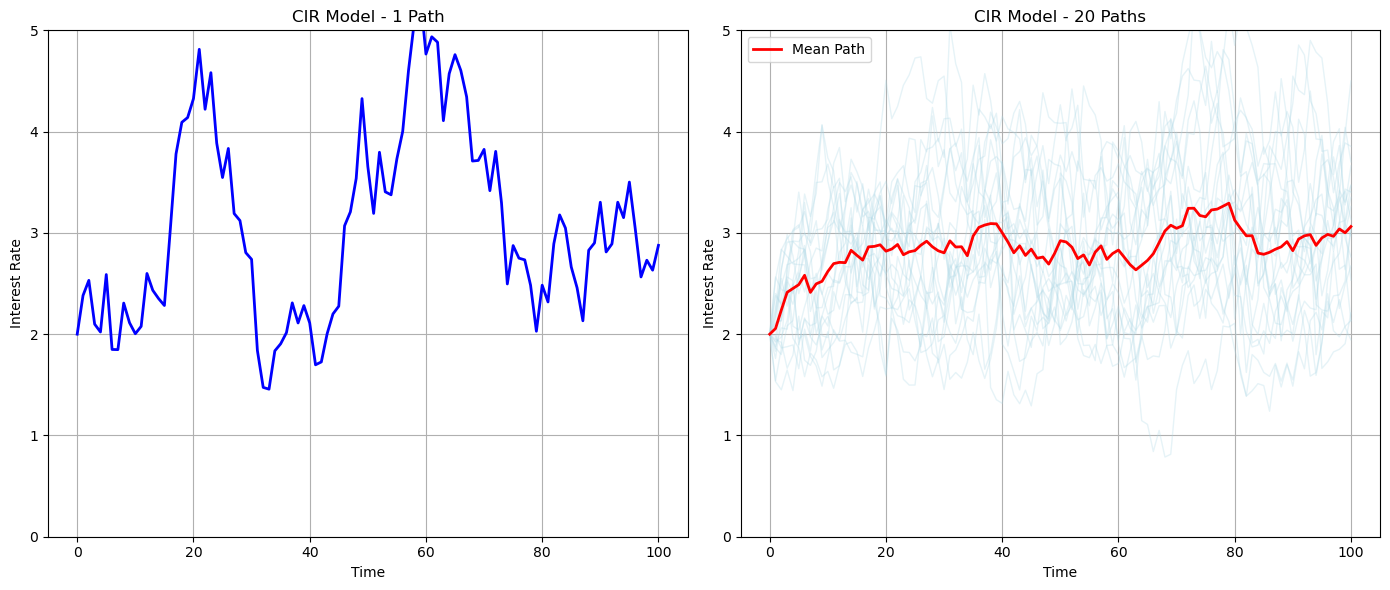

In [14]:
plt.figure(figsize=(14, 6))

# Left: Single example path
plt.subplot(1, 2, 1)
rate = cir_model(r0, k_true, theta_true, sigma, T, dt)
plt.plot(rate.index, rate['Interest Rate'], color='blue', linewidth=2)
plt.title('CIR Model - 1 Path')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.ylim([0, 5])  # zoomed out y-limit

nn = 20
# Right: Multiple example paths
rate_series = pd.DataFrame()  # to collect all paths

# Right: Multiple example paths
plt.subplot(1, 2, 2)
for i in range(nn):
    rate = cir_model(r0, k_true, theta_true, sigma, T, dt)
    plt.plot(rate.index, rate['Interest Rate'], color='lightblue', alpha=0.3, linewidth=1)
    
    # Add this path to rate_series
    # Assuming rate.index is a datetime or something consistent
    rate_series[f'path_{i+1}'] = rate['Interest Rate'].values

# After loop: compute mean across all paths at each time
mean_path = rate_series.mean(axis=1)

# Plot mean in red, thicker line
plt.plot(rate.index, mean_path, color='red', linewidth=2, label='Mean Path')

plt.title(f'CIR Model - {nn} Paths')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.ylim([0, 5])
plt.legend()

plt.tight_layout()
plt.show()


There are multiple more affine term structure models out there.

### Comparison of Short Rate Models: Ho-Lee, Hull-White, and Black-Karasinski

| Feature                         | Ho-Lee Model                       | Hull-White Model                    | Black-Karasinski Model             |
|---------------------------------|------------------------------------|-------------------------------------|------------------------------------|
| **Mean-Reversion**             | No                                 | Yes                                 | Yes                                |
| **Volatility Structure**        | Constant                           | Deterministic (time-dependent)      | Deterministic (time-dependent)     |
| **Stochastic Process**          | Normally distributed short rates   | Normally distributed short rates    | Lognormally distributed short rates|
| **SDE (Stochastic Differential Equation)** | dr = θ(t) dt + σ dWₜ                          | dr = [θ(t) - a·r] dt + σ dWₜ                            | d(ln r) = [θ(t) - a·ln r] dt + σ dWₜ                     |
| **Negative Rates Allowed**      | ✅ Yes                                          | ✅ Yes                                                   | ❌ No (rates are strictly positive)                      |
| **Model Linearity**             | Linear (additive noise)                        | Linear (mean-reverting)                                 | Non-linear (multiplicative noise)                        |



In [16]:
def ho_lee_model(r0: float, 
                 mu: float, 
                 sigma: float, 
                 T: int, 
                 dt: float) -> pd.DataFrame:
    """
    Simulates a time series of interest rates using the Ho-Lee model.

    The Ho-Lee model assumes that the short rate follows:
    dr(t) = mu * dt + sigma * dW(t)

    Args:
      r0 (float): Initial interest rate.
      mu (float): Constant drift rate (trend).
      sigma (float): Volatility of the rate.
      T (int): End modeling time. Time series runs from 0 to T.
      dt (float): Time increment (e.g., 0.1 means 10 steps per unit of time).

    Returns:
      pd.DataFrame: Time-indexed DataFrame with a single column of simulated interest rates.
    """
    N = int(T / dt) + 1
    time = np.linspace(0, T, N)
    r = np.zeros(N)
    r[0] = r0

    for t in range(1, N):
        Z = np.random.normal()
        r[t] = r[t-1] + mu * dt + sigma * np.sqrt(dt) * Z

    df = pd.DataFrame({'Interest Rate': r}, index=time)
    df.index.name = 'Time'
    return df


In [17]:
def hull_white_model(r0: float, 
                     a: float, 
                     theta: float, 
                     sigma: float, 
                     T: float, 
                     dt: float) -> pd.DataFrame:
    """
    Simulates interest rate path using the Hull-White model with constant θ.

    dr = [θ - a * r(t)] dt + σ dW(t)
    """
    N = int(T / dt) + 1
    time = np.linspace(0, T, N)
    r = np.zeros(N)
    r[0] = r0

    for t in range(1, N):
        Z = np.random.normal()
        r[t] = r[t-1] + (theta - a * r[t-1]) * dt + sigma * np.sqrt(dt) * Z

    return pd.DataFrame({'Interest Rate': r}, index=time).rename_axis("Time")

In [18]:
def black_karasinski_model(r0: float, 
                           a: float, 
                           b: float, 
                           sigma: float, 
                           T: float, 
                           dt: float) -> pd.DataFrame:
    """
    Simulates interest rate path using the Black-Karasinski model.

    d(ln r) = a (b - ln r) dt + sigma dW(t)
    """
    N = int(T / dt) + 1
    time = np.linspace(0, T, N)
    r = np.zeros(N)
    r[0] = r0

    for t in range(1, N):
        Z = np.random.normal()
        ln_r_prev = np.log(r[t-1])
        ln_r = ln_r_prev + a * (b - ln_r_prev) * dt + sigma * np.sqrt(dt) * Z
        r[t] = np.exp(ln_r)

    return pd.DataFrame({'Interest Rate': r}, index=time).rename_axis("Time")

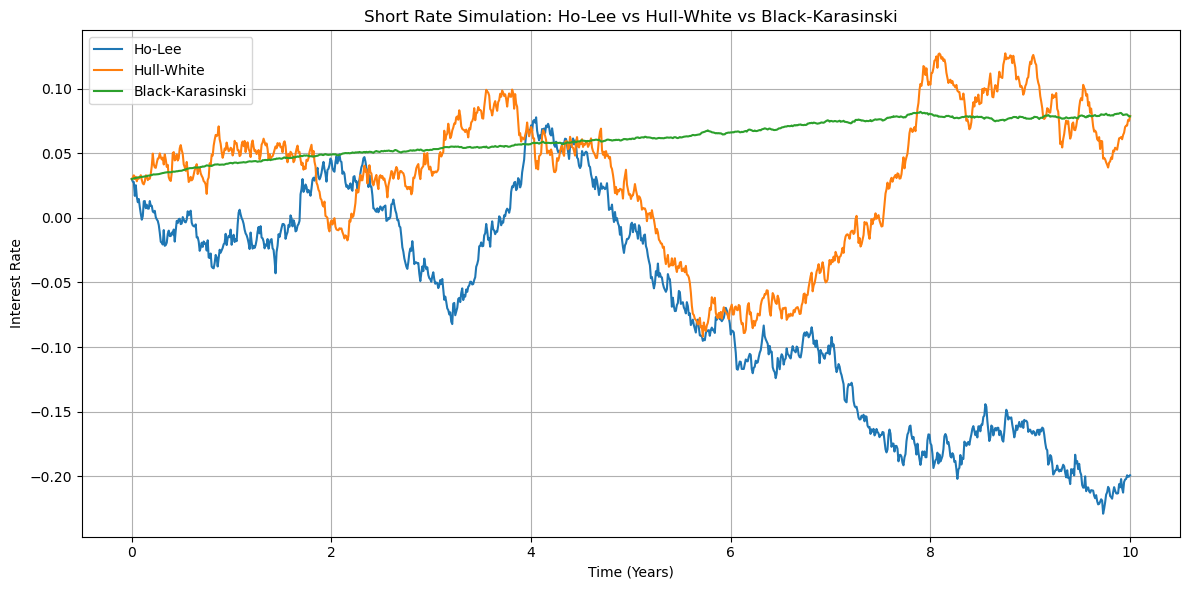

In [26]:
np.random.seed(2)

# Simulation parameters
r0 = 0.03       # initial rate
mu = 0.001      # drift for Ho-Lee
a = 0.3         # mean reversion speed
theta = 0.02    # long-term mean for Hull-White
b = np.log(0.08)  # mean reversion level for log(rate) in Black-Karasinski
sigma = 0.05    # volatility
T = 10          # years
dt = 0.01       # time step

# Simulate all models
hl_df = ho_lee_model(r0, mu, sigma, T, dt)
hw_df = hull_white_model(r0, a, theta, sigma, T, dt)
bk_df = black_karasinski_model(r0, a, b, sigma, T, dt)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(hl_df, label='Ho-Lee')
plt.plot(hw_df, label='Hull-White')
plt.plot(bk_df, label='Black-Karasinski')
plt.title('Short Rate Simulation: Ho-Lee vs Hull-White vs Black-Karasinski')
plt.xlabel('Time (Years)')
plt.ylabel('Interest Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


OK so we got some interesting observations. First Ho-Lee turns negative and trends more than the other models owing to it having a drift term but not having a mean-reversion feature in the model. The Black-Karasinski model instead is very steady due to its lognormal dynamics suppressing rate movement due to low volatility and initial log(r) near b.

Let's now turn to another aspect of rate analysis. We'll download data for the US Treasury yield curve and analyze their comovements and split the yield curve up into their principal components to better understand the dynamics.

In [27]:
import ustreasurycurve as ustcurve
ustcurve = ustcurve.nominalRates()
ustcurve.set_index('date', inplace=True)
ustcurve = ustcurve.drop(labels=['1m', '1.5m', '2m', '4m', '20y'], axis=1)
ustcurve = ustcurve.dropna()
ustcurve = ustcurve[ustcurve.index >= '2007-01-01']
ustcurve

,3m,6m,1y,2y,3y,5y,7y,10y,30y
date,,,,,,,,,
2007-01-02,5.07,5.11,5.00,4.80,4.71,4.68,4.68,4.68,4.79
2007-01-03,5.05,5.09,4.98,4.76,4.69,4.66,4.66,4.67,4.77
2007-01-04,5.04,5.07,4.95,4.71,4.63,4.61,4.61,4.62,4.72
2007-01-05,5.05,5.09,4.98,4.76,4.68,4.65,4.65,4.65,4.74
2007-01-08,5.08,5.13,5.01,4.78,4.70,4.66,4.66,4.66,4.74
...,...,...,...,...,...,...,...,...,...
2025-06-13,4.45,4.30,4.09,3.96,3.90,4.02,4.20,4.41,4.90
2025-06-16,4.43,4.32,4.10,3.97,3.93,4.04,4.23,4.46,4.96
2025-06-17,4.42,4.31,4.10,3.94,3.90,3.99,4.17,4.39,4.88


So we do have 2 T-bills and 7 Treasury bonds and notes. Let's first plot how they co-move and the yield curve shape of the last observation.

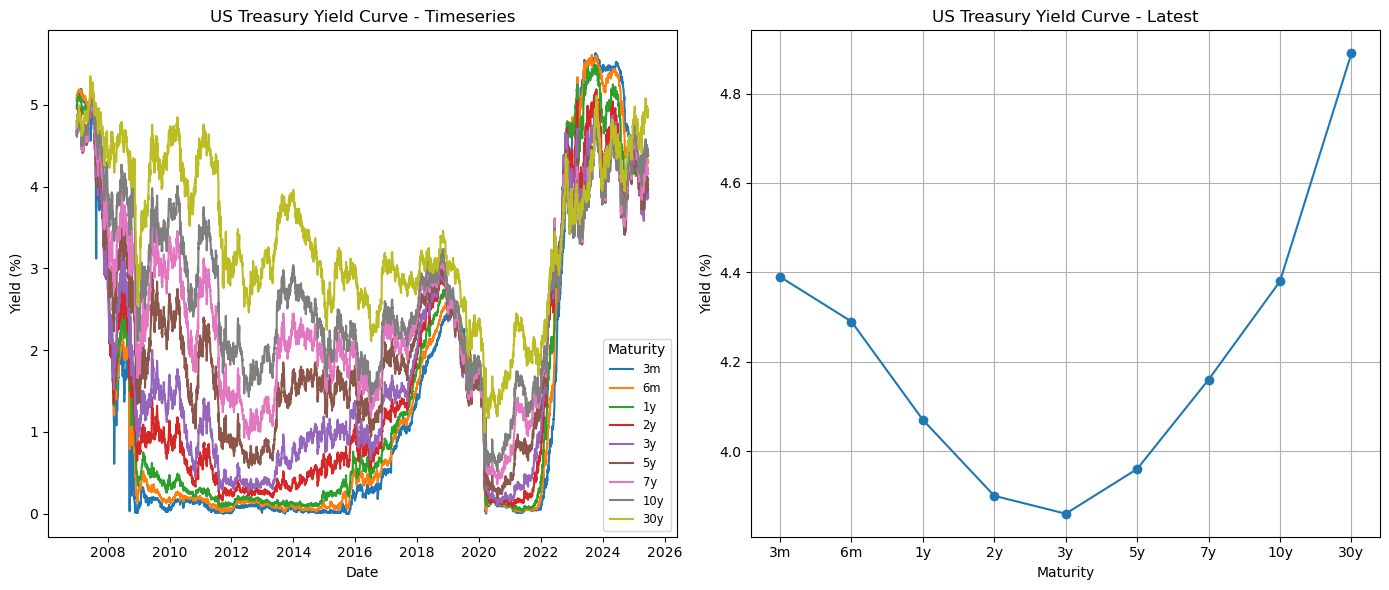

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax[0].plot(ustcurve.index, ustcurve.values)
ax[0].set_title('US Treasury Yield Curve - Timeseries')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Yield (%)')
ax[0].legend(ustcurve.columns, title='Maturity', fontsize='small')

# Right plot: latest yield curve snapshot
ax[1].plot(ustcurve.columns, ustcurve.iloc[-1].values, marker='o')
ax[1].set_title('US Treasury Yield Curve - Latest')
ax[1].set_xlabel('Maturity')
ax[1].set_ylabel('Yield (%)')
ax[1].grid(True)

plt.tight_layout()
plt.show()

OK, on the left we see all the rates and how they evolve over time. In 2008, rates were cut in response to the global financial crisis. Shorter maturity rates dropped sharply whereas longer-term rates fell much less as they are less connected to the short end of the curve. Afterwards, short-term rates held near zero for several years whereas longer term rates fluctuated. In 2021-2022, rates began to move upwards in anticipation and in response to the Fed raising rates. On the right we can see the last data points across the curve. According to the expectations hypothesis, this would suggest that the market believes the Fed will lower rates over the coming years and the curve bottoms out around the 3y point to then be higher in the long end of the curve. But there are other hypotheses as to what explains the yield curve shape, like segmentation hypothesis in where different type of actors are more active in different parts of the curve for example which helps explain the dynamic.

We can actually combine the two plots into one 3d plot which shows the time series on one axis, the term structure on one axis and the yield on one axis.

C:\Users\Gaming\AppData\Local\Temp\ipykernel_31136\1105679327.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(d.date()) for d in dates[xtick_locs]], rotation=30, ha='right')
C:\Users\Gaming\AppData\Local\Temp\ipykernel_31136\1105679327.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ustcurve.columns)
C:\Users\Gaming\AppData\Local\Temp\ipykernel_31136\1105679327.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


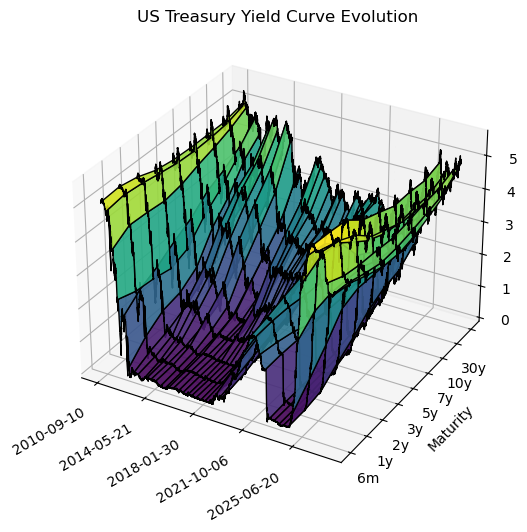

In [29]:
from mpl_toolkits.mplot3d import Axes3D

maturities = np.arange(len(ustcurve.columns))  # uniform spacing
dates = ustcurve.index

# Step 2: Prepare meshgrid
X, Y = np.meshgrid(np.arange(len(dates)), maturities)
Z = ustcurve.T.values  # Shape: (maturities, dates)

# Step 3: Plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.9)

# Step 4: Customize axes
ax.set_ylabel('Maturity')
ax.set_zlabel('Yield (%)')
ax.set_title('US Treasury Yield Curve Evolution')

# Show ~6 readable date labels
xtick_locs = np.linspace(0, len(dates)-1, 6, dtype=int)
ax.set_xticklabels([str(d.date()) for d in dates[xtick_locs]], rotation=30, ha='right')
ax.set_yticklabels(ustcurve.columns)
plt.tight_layout()
plt.show()


So rates are clearly moving in conjunction and there is a high degree of correlation. Let's scale all rates to make them more comparable and then calculate the covariance matrix to see their correlation. 

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(np.array(ustcurve)))
df_scaled.columns = ustcurve.columns


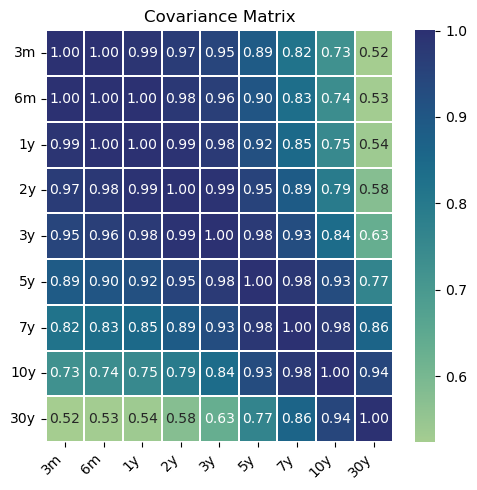

In [31]:
import seaborn as sns
X = np.array(df_scaled)
cov = (X.T @ X) / (X.shape[0] - 1)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(
    cov,
    cmap='crest',
    linecolor='white',
    linewidths=0.1,
    annot=True,
    fmt=".2f",
    xticklabels=df_scaled.columns,
    yticklabels=df_scaled.columns,
    ax=ax
)
ax.set(title="Covariance Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

With this at hand we can retrieve the principal components from the rates that explain the majority of the variance.

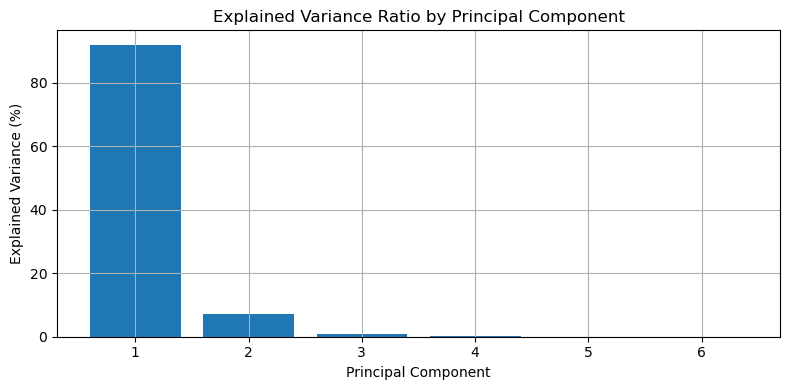

In [83]:
pca = PCA(n_components=6)
pca.fit(ustcurve)

explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_var) + 1), explained_var * 100)
plt.xticks(range(1, len(explained_var) + 1))
plt.ylabel("Explained Variance (%)")
plt.xlabel("Principal Component")
plt.title("Explained Variance Ratio by Principal Component")
plt.grid(True)
plt.tight_layout()
plt.show()



So the first three principal components explain more than 99% of the variance. Let's plot them.

(4618, 3)


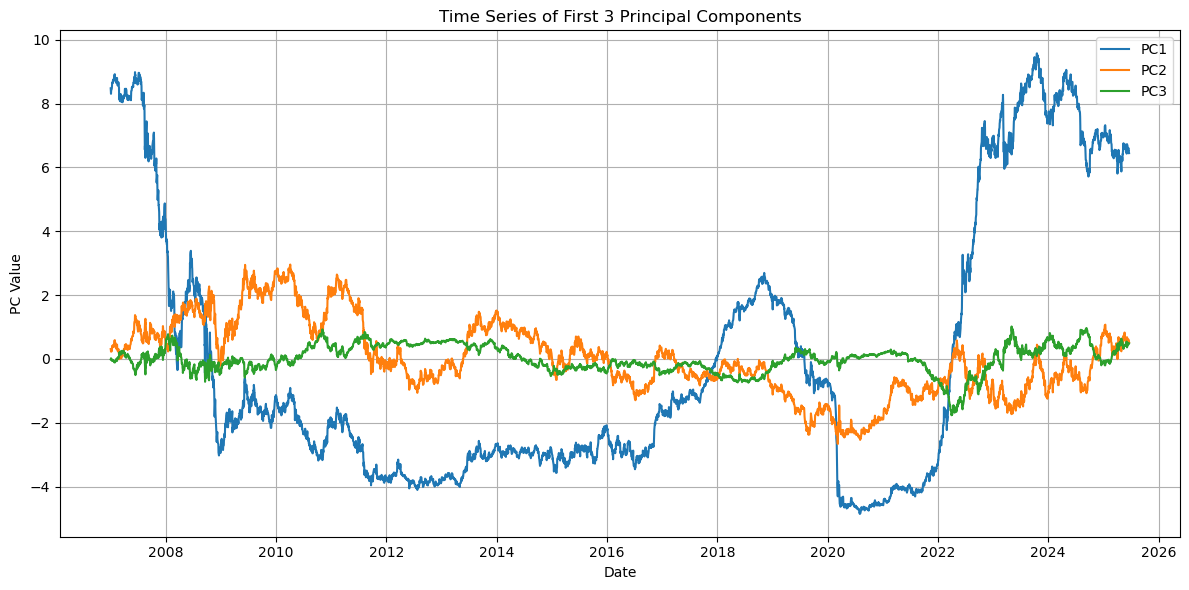

In [93]:
pca = PCA(n_components=3)
pca.fit(ustcurve)
X_pca = pca.transform(ustcurve)
print(X_pca.shape)

plt.figure(figsize=(12, 6))

for i in range(3):
    plt.plot(ustcurve.index, X_pca[:, i], label=f'PC{i+1}')

plt.title('Time Series of First 3 Principal Components')
plt.xlabel('Date')
plt.ylabel('PC Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

So it is commonly argued that the first principal component corresponds to the level of the yield curve. As we can see in blue the level first drops around 2008 and increases sharply in 2022, which is in line with our earlier finding. The second principal component typically explain the slope of the curve. We can see that it turns clearly positive around 2009 and 2010 as shorter rates fell much more than longer rates and has been negative in more recent years when the yield curve has been more flat. Lastly, the third principal component typically corresponds to the curvature or flexing of the curve, i.e. explaining the hump shape of the curve. 